In [1]:
import freud
import gsd
import gsd.pygsd
import gsd.hoomd
import signac
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import cycler
from scipy.stats import linregress
import cycler
from matplotlib.lines import Line2D

In [2]:
data_path= "/home/erjank_project/itic-project/"
project = signac.get_project(data_path)

In [3]:
def atom_type_pos(snap, atom_type):
    if not isinstance(atom_type, list):
        atom_type = [atom_type]
    positions = []
    for atom in atom_type:
        indices = np.where(snap.particles.typeid == snap.particles.types.index(atom))
        positions.append(snap.particles.position[indices])
    return np.concatenate(positions)

def msd_slope(job, step_size = 2, atom_types='all'):  
    msd = np.genfromtxt(job.fn('msd.log'), names=True, delimiter="\t")
    x = msd['timestep'][-3000::step_size]
    y = msd[atom_types][-3000::step_size]
    slope, intercept, r_value, p_value, std_err = linregress(x, y)
    return x, y, slope

def msd_from_gsd(gsdfile, start=-30, stop=-1, atom_type='ss', msd_mode = "window"):
    f = gsd.pygsd.GSDFile(open(gsdfile, "rb"))
    trajectory = gsd.hoomd.HOOMDTrajectory(f)
    positions = []
    for frame in trajectory[start:stop]:
        if atom_type == 'all':
            atom_positions = frame.particles.position[:]
        else:
            atom_positions = atom_type_pos(frame, atom_type)
        positions.append(atom_positions)
    msd = freud.msd.MSD(box=trajectory[-1].configuration.box, mode=msd_mode)
    msd.compute(positions)
    f.close()
    return(msd.msd) # This is retruning an array of numbers (the y-axis on the msd plot)

In [4]:
data_path= "/home/erjank_project/itic-project/"
project = signac.get_project(data_path)
state_dict = {"size": "small",
              "density": 0.9,
              "molecule": "ITIC",
              "process": "quench"}
job_list = project.find_jobs(state_dict)
for job in job_list:
    msd = msd_from_gsd(job.fn('trajectory.gsd'))
    y = msd[-15:]
    tspf = job.sp['n_steps'] / 100
    x = np.arange(0, len(y), 1) * tspf
    slope, intercept, r_value, p_value, std_err = linregress(x, y)
    job.doc['msd_slope'] = slope
    job.doc['msd_slope_r2'] = r_value

## Plotting MSD at constant density

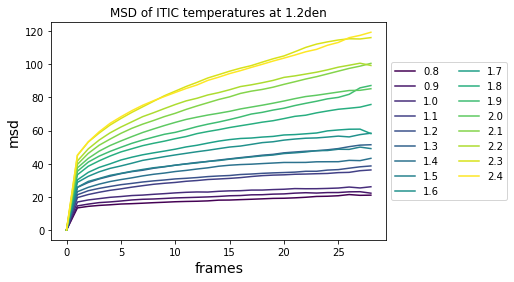

In [38]:
state_dict = {"size": "small",
              "density": 1.2,
              "molecule": "ITIC",
              "process": "quench"}

job_list = project.find_jobs(state_dict)
fig = plt.figure()
ax = plt.subplot(111)
state_dict['density.$lt'] = 1.3
color = plt.cm.viridis(np.linspace(0, 1, len(job_list)))
mpl.rcParams['axes.prop_cycle'] = cycler.cycler('color', color)
for kT,job in job_list.groupby('kT_reduced'):
    job = list(job)[0]
    msd = msd_from_gsd(job.fn('trajectory.gsd'), atom_type='all')
    tspf = job.sp['n_steps'] / 100
    y = msd
    x = range(len(y)) 
    plt.plot(x, y, label=kT)
plt.title("MSD of ITIC temperatures at %sden" % (job.sp['density']))
plt.xlabel("frames", fontsize=14)
plt.ylabel("msd", fontsize=14)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=2)
plt.show()

## Plotting slope vs. temp

#### constant density

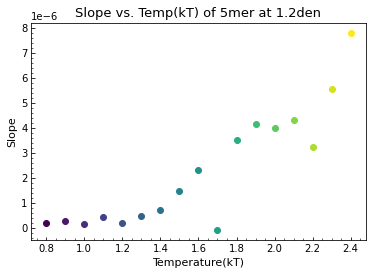

In [43]:
state_dict = {'size': 'small', 'process': 'quench', "density": 1.2, "molecule":"ITIC" }
job_list = project.find_jobs(state_dict)
fig = plt.figure()
ax = plt.subplot(111)
state_dict['kT_reduced.$lt'] = 2.5
color = plt.cm.viridis(np.linspace(0, 1, len(job_list)))
mpl.rcParams['axes.prop_cycle'] = cycler.cycler('color', color)

for temp,job in job_list.groupby('kT_reduced'):
    job = list(job)[0]
    msd = msd_from_gsd(job.fn('trajectory.gsd'))
    slope = job.doc['msd_slope']
    x2=job.sp["kT_reduced"]
    y2=slope
    plt.scatter(x2,y2, label=temp)
    ax.minorticks_on()
    ax.tick_params(axis='both', which='both', direction='in', labelsize=10)
plt.title("Slope vs. Temp(kT) of 5mer at %sden" % (job.sp['density']), fontsize=13 )
plt.xlabel("Temperature(kT)", fontsize=11)
plt.ylabel("Slope", fontsize=11)
plt.show()

#### Multiple polymer lengths

In [47]:
#jokes on me, itic doesnt have multiple polymer lengths